In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import configs

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from predify.utils.training import train_pcoders, eval_pcoders

from models.networks_2022 import BranchedNetwork

In [2]:
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

# Parameters

In [4]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}1_checkpoints/'
tensorboard_dir = f'{engram_dir}1_tensorboard/'
activations_dir = f'{engram_dir}3_activations/'

In [32]:
models = ['pnet_merged', 'temp_shuffle_merged', 'freq_shuffle_merged', ]
model_names = ['Main', 'Temp. Shuffle','Freq. Shuffle', ]

In [24]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cuda:0


# Helper functions

In [25]:
def get_accuracy(results):
    labels = np.array(results['label'])
    timesteps = []
    accuracies = [] # p
    delta_accuracies = [] # p - p_ff
    
    n_timesteps = 5
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'{t}_output'][i]
            acc_t = (output == label).astype(float)
            if t == 0:
                ff_acc = acc_t
            timesteps.append(t)
            accuracies.append(acc_t)
            delta_accuracies.append(acc_t - ff_acc)

    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    delta_accuracies = np.array(delta_accuracies)
            
    return timesteps, accuracies, delta_accuracies

In [26]:
def get_data(model):
    data = {}
    data['Accuracy'] = [] # p
    data['$\Delta$ Accuracy'] = [] # p - p_ff for each bg, snr
    data['Timesteps'] = []
    data['SNR'] = []
    data['BG'] = []
    data['ID'] = []

    for bg in bgs:
        for snr in snrs:
            activ_dir = f'{activations_dir}{model}/{bg}_snr{int(snr)}/'
            for results_file in os.listdir(activ_dir):
                results_filepath = f'{activ_dir}{results_file}'
                try:
                    results = h5py.File(results_filepath, 'r')
                except:
                    print(results_filepath)
                    traceback.print_exc()
                    continue
                timesteps, accs, delta_accs = get_accuracy(results)

                # Collect accuracy results by labels
                for t in [0, 1, 2, 3, 4]:
                    idxs = timesteps==t
                    data['Accuracy'].append(np.mean(accs[idxs]))
                    data['$\Delta$ Accuracy'].append(np.mean(delta_accs[idxs]))
                    data['Timesteps'].append(t)
                    data['SNR'].append(snr)
                    data['BG'].append(bg)
                    data['ID'].append(results_file)
    df = pd.DataFrame(data)

    bg_avgs = {}
    for bg in np.unique(df['BG']):
        bg_avgs[bg] = {}
        for snr in np.unique(df['SNR']):
            ff_df = df[df['Timesteps']==0]
            bg_avgs[bg][snr] = np.mean(
                ff_df[(ff_df['BG'] == bg) & (ff_df['SNR'] ==snr)]['Accuracy']
                )
    data['Relative Accuracy'] = [] # (p - p_ff)/p_ff
    for idx in range(len(data['Accuracy'])):
        bg = data['BG'][idx]
        snr = data['SNR'][idx]
        delta_acc = data['$\Delta$ Accuracy'][idx]
        data['Relative Accuracy'].append(delta_acc/bg_avgs[bg][snr])
    df = pd.DataFrame(data)
    return df

# Plot over SNR

In [27]:
bgs = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snrs = [-9.0, -6.0, -3.0, 0.0, 3.0]

In [28]:
model_dfs = []
for model in models:
    model_dfs.append(get_data(model))

In [33]:
model_dfs = [model_dfs[0], model_dfs[2], model_dfs[1]]

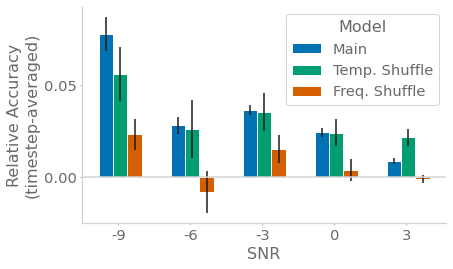

In [34]:
barWidth = 0.2
x1 = np.arange(5) - barWidth*1.75/2
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))
colors = ['C0', 'C2', 'C3', 'C4']

for snr_i, snr in enumerate(np.unique(model_dfs[0]['SNR'])):
    t = 4
    for model_idx, model in enumerate(models):
        model_name = model_names[model_idx]
        model_df = model_dfs[model_idx]
        df = model_df[(model_df['SNR']==snr) & (model_df['BG']!='Babble8Spkr')]
        vals = df['Relative Accuracy']
        vals = np.array(vals)
        avg = np.mean(vals)
        err = sem(vals)
        label = model_name if snr_i==0 else None
        plt.bar(
            x1[snr_i] + barWidth*model_idx, avg,
            width=barWidth, color=colors[model_idx],
            yerr=err, capsize=0, label=label)
plt.xticks([0,1,2,3,4], [-9, -6, -3, 0, 3])
plt.ylabel('Relative Accuracy\n(timestep-averaged)')
plt.xlabel('SNR')
plt.axhline(0, color='lightgray')
plt.legend(title='Model')
plt.yticks([0., 0.05])
plt.tight_layout()
plt.savefig('control.png', dpi=300)
plt.show()

# Plot over BG

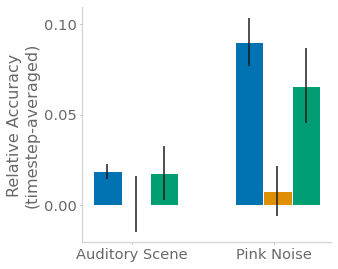

In [12]:
barWidth = 0.2
x1 = np.arange(5) - barWidth*1.75/2
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.8))

for bg_i, bg in enumerate(['AudScene', 'pinkNoise']):
    t = 4
    for model_idx, model in enumerate(models):
        model_name = model_names[model_idx]
        model_df = model_dfs[model_idx]
        df = model_df[(model_df['BG']==bg) & (model_df['Timesteps']==t)]
        vals = df['Relative Accuracy']
        vals = np.array(vals)
        avg = np.mean(vals)
        err = sem(vals)
        plt.bar(
            x1[bg_i] + barWidth*model_idx, avg, yerr=err,
            width=barWidth, color=colors[model_idx],
            label=t)
plt.xticks(
    [0, 1],
    ['Auditory Scene', 'Pink Noise'])
plt.ylabel('Relative Accuracy\n(timestep-averaged)')
plt.yticks([0., 0.05, 0.1])
plt.tight_layout()
plt.savefig('control_bg.png', dpi=300)
plt.show()